<a href="https://colab.research.google.com/github/neel26desai/cmpe255_clustering/blob/main/AnomalyDetectionPyOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyod


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.2-py3-none-any.whl size=190289 sha256=57a545f78e8ee993863df0ab4e431554d44b6c8afafc2674184cd1406296ccd8
  Stored in directory: /root/.cache/pip/wheels/81/1b/61/aa85b78c3c0c8871f4231e3f4a03bb23cecb7db829498380ee
Successfully built pyod


Datasets: https://finance.yahoo.com/quote/AMZN/history/?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAAMuGCpu9ITtMd4RXHUVuIlccTDk9r8kpnqwKRdf3_r_L9N535ECGAO1twBOCNZLhXu-vB54aYllBK9WkW1g39iHjcIf8z1jOgcF5yb1iJcDN20NfG40g534bVgHb5FMlq7w8E2zQrw9Fs0UemwXYacB6WY_Y1js6ecgicPkBJ1kA

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('/content/drive/MyDrive/AMZN_2006-01-01_to_2018-01-01.csv')

In [4]:
df.describe()

,Open,High,Low,Close,Volume
count,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03
mean,299.335310,302.371163,296.037695,299.376231,5.931712e+06
std,280.120547,281.826442,277.927134,279.980161,5.122034e+06
min,26.090000,26.300000,25.760000,26.070000,9.864350e+05
25%,81.175000,82.580000,79.725000,81.090000,3.137037e+06
50%,205.330000,208.000000,202.100000,205.440000,4.724100e+06
75%,375.570000,379.155000,373.000000,375.140000,7.135246e+06
max,1204.880000,1213.410000,1191.150000,1195.830000,1.044046e+08


In [5]:
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [6]:
#we'll primary focus on the closing price for anomaly detection
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
#let us drop open.high,low,volumns and Name
df.drop(['Open','High','Low','Volume','Name'],axis=1,inplace=True)

In [7]:
df.head()

,Close
Date,
2006-01-03,47.58
2006-01-04,47.25
2006-01-05,47.65
2006-01-06,47.87
2006-01-09,47.08


In [8]:
from matplotlib import pyplot as plt

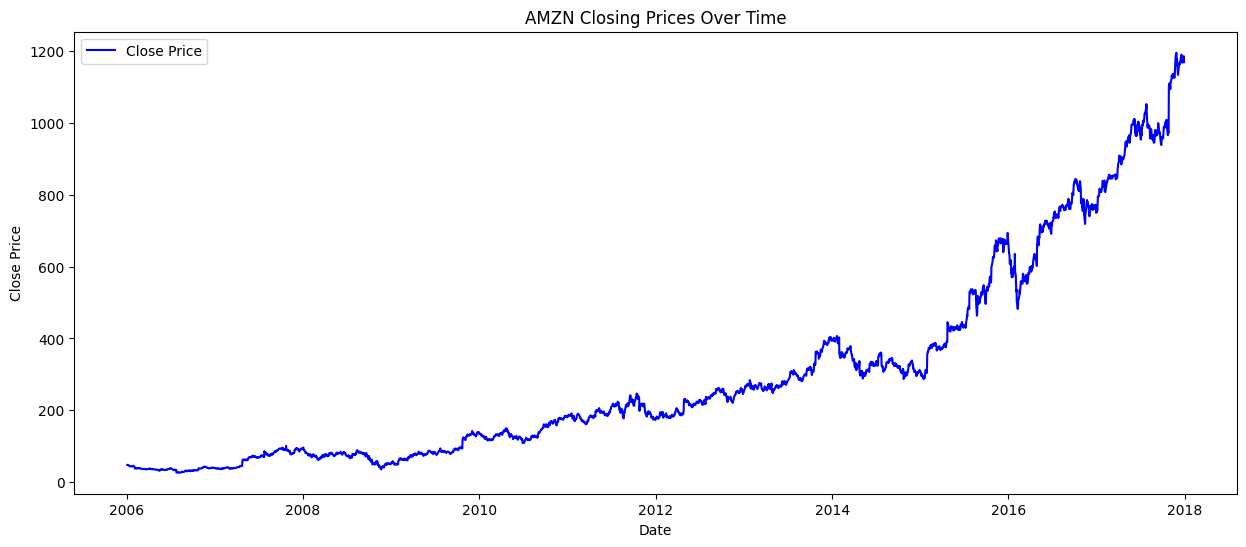

In [9]:
# Time series plot of the closing prices
plt.figure(figsize=(15, 6))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.title('AMZN Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [11]:
df.isna().sum()

Close    0
dtype: int64

No Missing values, so one less thing to worry about

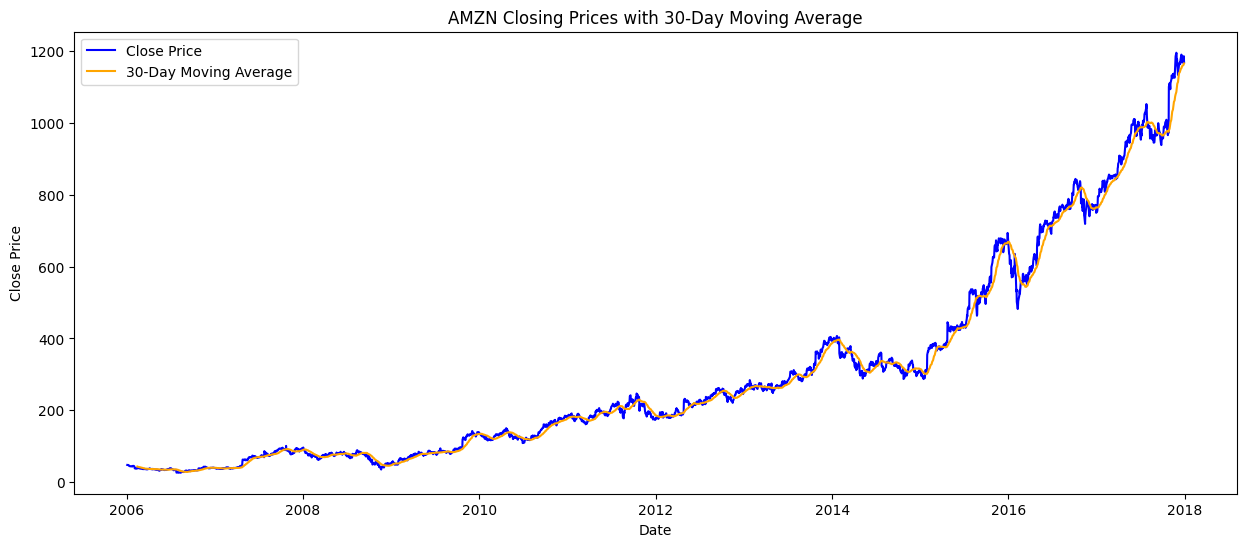

In [12]:
# Plotting a 30-day moving average for closing prices
df['30_day_MA'] = df['Close'].rolling(window=30).mean()

plt.figure(figsize=(15, 6))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.plot(df['30_day_MA'], label='30-Day Moving Average', color='orange')
plt.title('AMZN Closing Prices with 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [13]:
#getting the trend, seasonality and reside information from the time series
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose



In [15]:
# Decomposing the time series
decomposition = seasonal_decompose(df['Close'], model='additive', period=30)  # assuming a monthly cycle

# Extracting the trend, seasonality, and residual components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

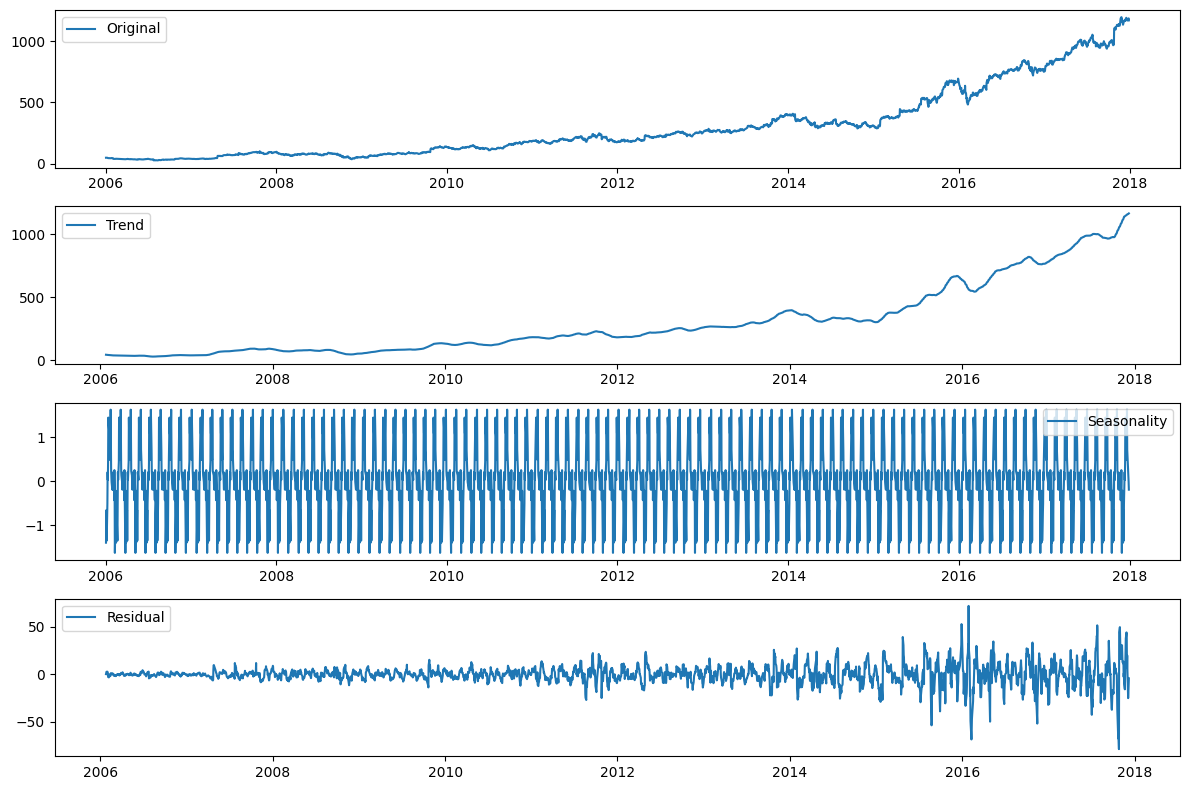

In [16]:
# Plotting the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df['Close'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout()

Based on the residual we ca say that we have a bund of anomalies betweeb 2016 to 2018

In [17]:
from pyod.models.iforest import IForest #we'll use the IForest model from pyod for anomaly detection

In [18]:
# Isolation Forest for anomaly detection
iforest = IForest(contamination=0.05)  # assuming approximately 5% of the data as outliers


In [20]:
# Reshape data for the model
close_prices = df['Close'].values.reshape(-1, 1)

In [22]:
# Fit the model
iforest.fit(close_prices)

IForest(behaviour='old', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=None, verbose=0)

In [23]:
# Predictions
labels = iforest.predict(close_prices)

# Adding labels to the original dataset for visualization
df['Anomaly'] = labels

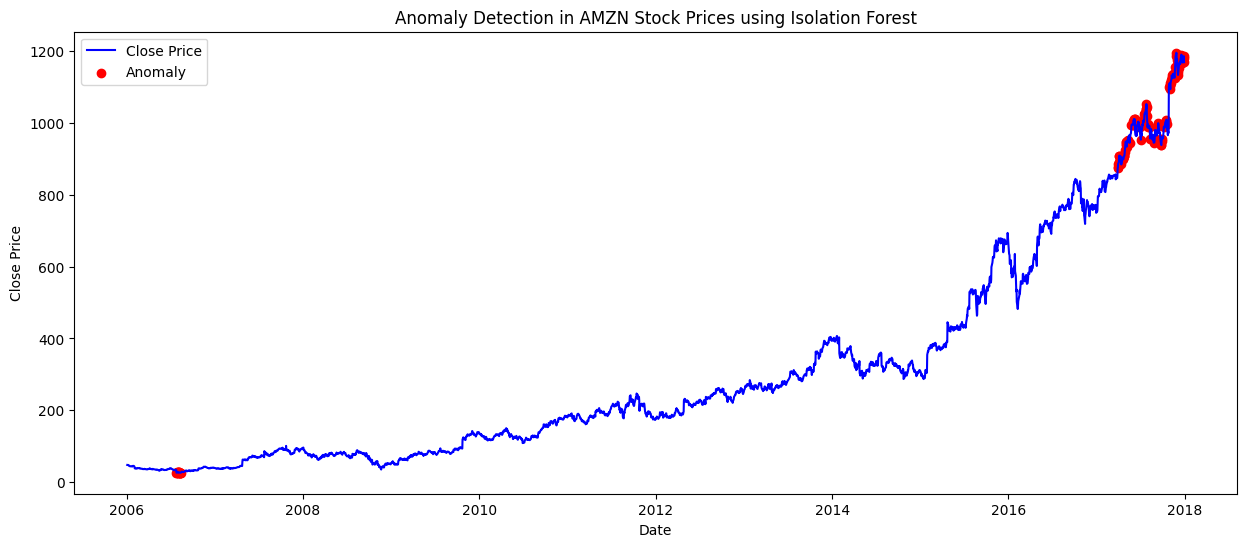

In [24]:
# Plotting the results
plt.figure(figsize=(15, 6))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.scatter(df.index[df['Anomaly'] == 1], df['Close'][df['Anomaly'] == 1], color='red', label='Anomaly')
plt.title('Anomaly Detection in AMZN Stock Prices using Isolation Forest')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

For multivariant

In [25]:
#using auto-encoder
from pyod.models.auto_encoder import AutoEncoder

In [28]:
df = pd.read_csv('/content/drive/MyDrive/AMZN_2006-01-01_to_2018-01-01.csv')
#we'll primary focus on the closing price for anomaly detection
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
#let us drop open.high,low,volumns and Name
df.drop(['Name'],axis=1,inplace=True)

In [30]:
features  = df[['Open','Close','Volume','High']]

In [31]:
from sklearn.preprocessing import StandardScaler

In [32]:
# Rescale the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(features)


In [33]:
# Initialize the AutoEncoder model
autoencoder = AutoEncoder(contamination=0.05, epochs=30,hidden_neurons=[len(features.columns), 2, 2, len(features.columns)])#we assume that 5% of the data is anomaly

In [34]:
# Fit the model
autoencoder.fit(data_scaled)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 20        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dropout_2 (Dropout)         (None, 4)                 0         
                                                                 
 dense_3 (Dense)             (None, 2)                 1

AutoEncoder(batch_size=32, contamination=0.05, dropout_rate=0.2, epochs=30,
      hidden_activation='relu', hidden_neurons=[4, 2, 2, 4],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7bf00293cc10>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

In [ ]:
# Predict anomalies
predictions = autoencoder.predict(data_scaled)


In [38]:
# Adding anomaly labels to the original dataset for visualization
df['Anomaly'] = predictions

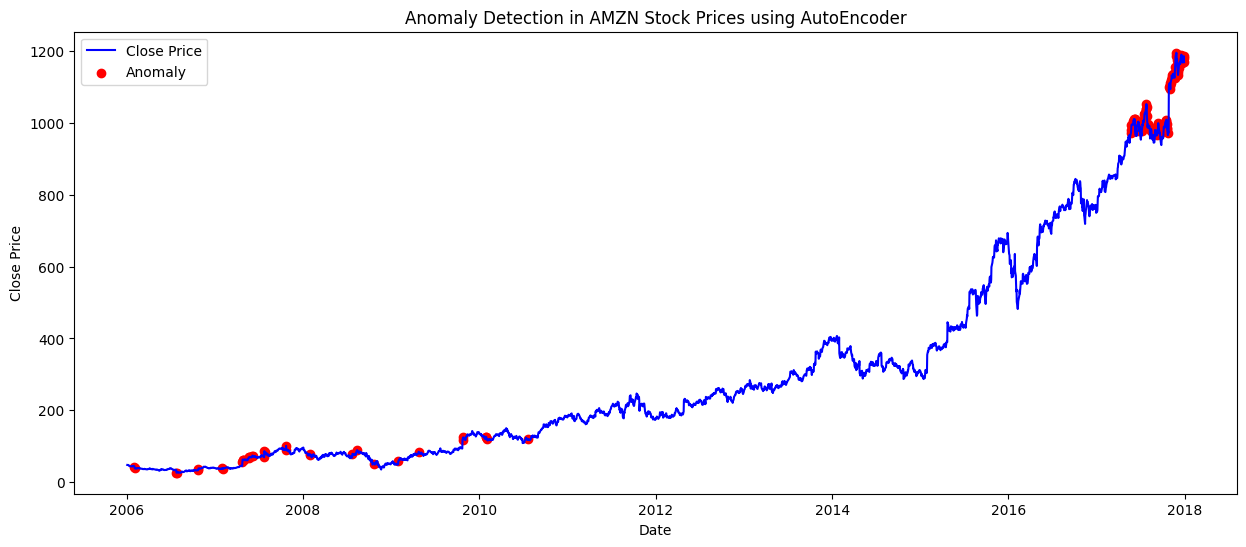

In [40]:
# Plotting the results
plt.figure(figsize=(15, 6))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.scatter(df.index[df['Anomaly'] == 1], df['Close'][df['Anomaly'] == 1], color='red', label='Anomaly')
plt.title('Anomaly Detection in AMZN Stock Prices using AutoEncoder')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

Using autoencoder and multivariant anlysis we can identify other anomalies which we werent able to identify previously